# Validation

**Learning Objectives:**
1. Use mutliple features instead of single feature to further improve the model
2. Debug issue in model input data
3. Use test data set to check model is overfitting the validation data.

### Importing modules

In [39]:
import pandas as pd

from matplotlib import pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow.python.data import Dataset

import math

from sklearn import metrics

# Good to have configs and modules
tf.logging.set_verbosity(tf.logging.ERROR)

### Importing dataset

In [2]:
california_housing_dataframe = pd.read_csv("https://dl.google.com/mlcc/mledu-datasets/california_housing_train.csv", sep=",")

### Preprocess features

In [3]:
def preprocess_features(california_housing_dataframe):
    """Prepares input features from california housing dataframe.
    Args:
        california_housing_dataframe: A pandas dataframe expected to contain data
        from the California housing data set.
    Returns:
        A dataframe that contains features to be used by the model, including synthetic features.
    """
    selected_features = california_housing_dataframe[
        ["latitude",
        "longitude",
        "housing_median_age",
        "total_rooms",
        "total_bedrooms",
        "population",
        "households",
        "median_income"]
    ]
    processed_features = selected_features.copy()
    
    # Create synthetic features
    processed_features["rooms_per_person"] = (
        california_housing_dataframe["total_rooms"] /
        california_housing_dataframe["population"]
    )
    
    return processed_features

In [4]:
def preprocess_targets(california_housing_dataframe):
    """ Prepares target features (i.e. labels) from California housing dataset. 
    
    Args:
        california_housing_dataframe: A pandas dataframe expected to contain data 
        from California housing dataset.
    Returns:
        A dataframe that contains target features
    """
    
    output_targets = pd.DataFrame()
    # Scale the target to be in the units of Thousands of dollars
    output_targets["median_house_value"] = (
        california_housing_dataframe["median_house_value"] / 1000.0
    )
    return output_targets

For the **Training set**, we will choose the first 12000 examples, out of total 17000

In [5]:
training_examples = preprocess_features(california_housing_dataframe.head(12000))
training_examples.describe()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.00000,12000.000000,12000.000000
mean,34.614578,-118.470274,27.468333,2655.682333,547.057167,1476.007000,505.38425,3.795047,1.940185
std,1.625970,1.243589,12.061790,2258.147574,434.314754,1174.280904,391.71534,1.851925,1.327142
min,32.540000,-121.390000,1.000000,2.000000,2.000000,3.000000,2.00000,0.499900,0.018065
25%,33.820000,-118.940000,17.000000,1451.750000,299.000000,815.000000,283.00000,2.517200,1.420007
50%,34.050000,-118.210000,28.000000,2113.500000,438.000000,1207.000000,411.00000,3.462250,1.880875
75%,34.440000,-117.790000,36.000000,3146.000000,653.000000,1777.000000,606.00000,4.644625,2.258830
max,41.820000,-114.310000,52.000000,37937.000000,5471.000000,35682.000000,5189.00000,15.000100,55.222222


In [6]:
training_targets = preprocess_targets(california_housing_dataframe.head(12000))
training_targets.describe()

,median_house_value
count,12000.000000
mean,198.037593
std,111.857499
min,14.999000
25%,117.100000
50%,170.500000
75%,244.400000
max,500.001000


For the **validation set**, we will choose the remaining 5000 examples

In [7]:
validation_examples = preprocess_features(california_housing_dataframe.tail(5000))
validation_examples.describe()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000
mean,38.050778,-122.182510,31.27980,2614.821400,521.059600,1318.13460,491.232400,4.096053,2.078781
std,0.923030,0.480337,13.38939,1979.620397,388.452096,1073.74575,366.523912,2.021218,0.638113
min,36.140000,-124.350000,1.00000,8.000000,1.000000,8.00000,1.000000,0.499900,0.135721
25%,37.490000,-122.400000,20.00000,1481.000000,292.000000,731.00000,278.000000,2.690900,1.749190
50%,37.790000,-122.140000,31.00000,2164.000000,424.000000,1074.00000,403.000000,3.728450,2.066278
75%,38.370000,-121.910000,42.00000,3161.250000,635.000000,1590.25000,603.000000,5.064100,2.375372
max,41.950000,-121.390000,52.00000,32627.000000,6445.000000,28566.00000,6082.000000,15.000100,18.255319


In [8]:
validation_targets = preprocess_targets(california_housing_dataframe.tail(5000))
validation_targets.describe()

,median_house_value
count,5000.000000
mean,229.532879
std,122.520063
min,14.999000
25%,130.400000
50%,213.000000
75%,303.150000
max,500.001000


### Examine the Data

Seems there are some rediculos numbers up there:
1. The Latitude of training and validation set is quite different..
2. Rooms per person has some absurd values like 55 rooms per person (till 75th percentile it looks good).
3. Median_income scale is not clear
4. max median_house_value is 500,001. It looks like a cap

## Plot Latitude/Longitude vs. Median House Value

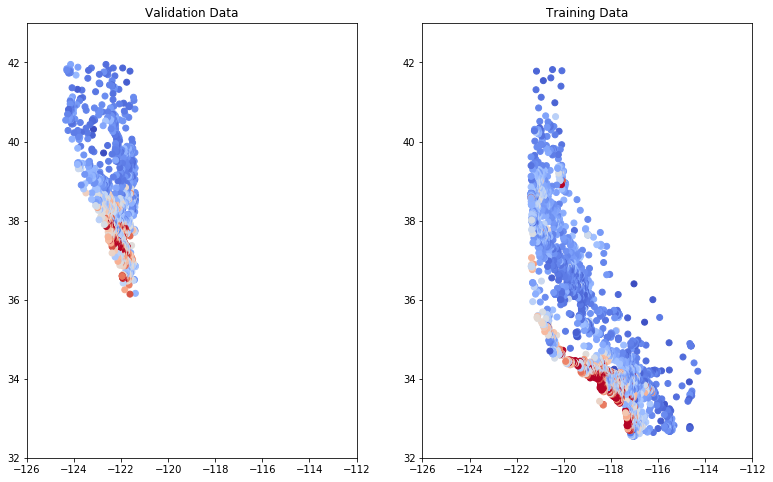

In [9]:
plt.figure(figsize=(13, 8))

ax = plt.subplot(1, 2, 1)
ax.set_title("Validation Data")

ax.set_autoscaley_on(False)
ax.set_ylim([32, 43])
ax.set_autoscalex_on(False)
ax.set_xlim([-126, -112])
plt.scatter(validation_examples["longitude"],
           validation_examples["latitude"],
           cmap="coolwarm",
           c=validation_targets["median_house_value"]/validation_targets["median_house_value"].max())

ax = plt.subplot(1,2,2)
ax.set_title("Training Data")
ax.set_autoscaley_on(False)
ax.set_ylim([32, 43])
ax.set_autoscalex_on(False)
ax.set_xlim([-126, -112])
plt.scatter(training_examples["longitude"],
           training_examples["latitude"],
           cmap="coolwarm",
           c=training_targets["median_house_value"]/training_targets["median_house_value"].max())

_ = plt.plot()

The validation data map doesn't look like california map at all. Go back to describe and compare it the the training data values.

**Key takeaway:** The distribution of values between train and validation splits should be roughly equal. In this case Latitude is not distributed equally between the two data sets. Why this error has come? Go back and see.

That's because our data is not randomized and it's used directly.

## Do all the steps again with the new randomized dataset.

In [10]:
california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index)
)

### Re-create train and validation set

We can give again first 12000 as train and remaining 5000 as test because now we've randomized the text

In [11]:
training_examples_randomized = preprocess_features(california_housing_dataframe.head(12000))
training_examples_randomized.describe()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000
mean,35.621307,-119.563434,28.591583,2639.076500,538.366833,1422.920000,500.159500,3.897126,1.980198
std,2.133444,2.005302,12.642162,2149.261945,418.426964,1106.108031,379.928454,1.909199,1.128036
min,32.550000,-124.300000,1.000000,2.000000,2.000000,6.000000,2.000000,0.499900,0.061605
25%,33.930000,-121.790000,18.000000,1463.000000,295.000000,792.000000,282.000000,2.575000,1.520265
50%,34.250000,-118.480000,29.000000,2122.000000,432.000000,1165.000000,408.000000,3.556200,1.943711
75%,37.720000,-118.000000,37.000000,3146.250000,646.000000,1715.250000,602.000000,4.777425,2.299386
max,41.950000,-114.310000,52.000000,32627.000000,6445.000000,28566.000000,6082.000000,15.000100,52.033333


In [12]:
training_targets_randomized = preprocess_targets(california_housing_dataframe.head(12000))
training_targets_randomized.describe()

,median_house_value
count,12000.000000
mean,208.653533
std,116.497663
min,14.999000
25%,121.000000
50%,181.100000
75%,266.400000
max,500.001000


In [13]:
validation_examples_randomized = preprocess_features(california_housing_dataframe.tail(5000))
validation_examples_randomized.describe()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,35.634628,-119.558926,28.584000,2654.67540,541.916400,1445.543400,503.771800,3.851063,1.982748
std,2.146846,2.005037,12.454652,2252.06724,428.815516,1242.302069,395.351967,1.905450,1.262578
min,32.540000,-124.350000,1.000000,8.00000,1.000000,3.000000,1.000000,0.536000,0.018065
25%,33.930000,-121.770000,18.000000,1460.00000,299.000000,784.750000,281.750000,2.542950,1.524278
50%,34.260000,-118.510000,29.000000,2142.00000,438.000000,1172.000000,412.000000,3.518400,1.933484
75%,37.710000,-118.000000,37.000000,3169.25000,657.000000,1738.000000,611.000000,4.736250,2.294650
max,41.860000,-114.570000,52.000000,37937.00000,5471.000000,35682.000000,5189.000000,15.000100,55.222222


In [14]:
validation_targets_randomized = preprocess_targets(california_housing_dataframe.tail(5000))
validation_targets_randomized.describe()

,median_house_value
count,5000.000000
mean,204.054622
std,114.687517
min,14.999000
25%,116.575000
50%,177.800000
75%,262.000000
max,500.001000


This time the distribution among the train and validation data set looks similar. Good for us.
Now let's draw the plot again

## Plot longitude/latitude vs Median house value on the Randomized datasets

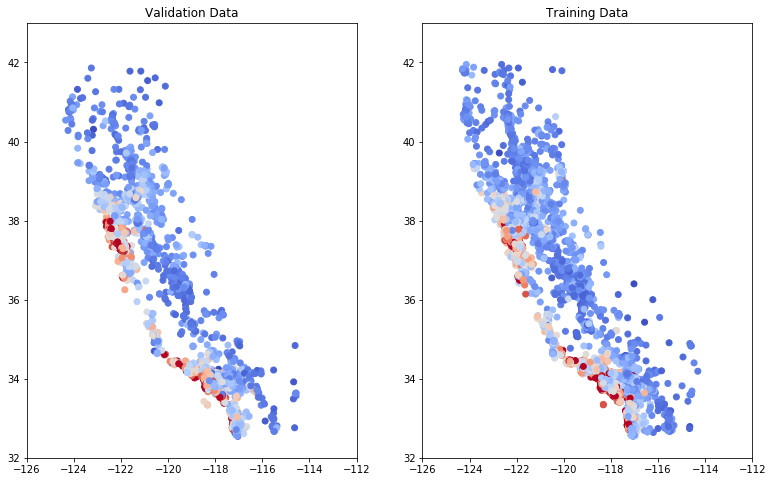

In [15]:
plt.figure(figsize=(13, 8))

ax = plt.subplot(1, 2, 1)
ax.set_title("Validation Data")
ax.set_autoscaley_on(False)
ax.set_ylim([32, 43])
ax.set_autoscalex_on(False)
ax.set_xlim([-126, -112])
plt.scatter(validation_examples_randomized["longitude"],
           validation_examples_randomized["latitude"],
           cmap="coolwarm",
           c=validation_targets_randomized["median_house_value"]/validation_targets_randomized["median_house_value"].max())


ax = plt.subplot(1, 2, 2)
ax.set_title("Training Data")
ax.set_autoscaley_on(False)
ax.set_ylim([32, 43])
ax.set_autoscalex_on(False)
ax.set_xlim([-126, -112])
plt.scatter(training_examples_randomized["longitude"],
           training_examples_randomized["latitude"],
           cmap="coolwarm",
           c=training_targets_randomized["median_house_value"]/training_targets_randomized["median_house_value"].max())

_ = plt.plot()

**This looks much better than our earlier scatter plot.**

## Train and evaluate the model

In [16]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """ Trains linear regression model of multiple features.
    
    Args:
        features: pandas dataframe of features
        targets: pandas dataframe of targets
        batch_size: Size of batches to be passed to the model
        shuffle: True or False, whether to shuffle the data
        num_epochs: Number of epochs for which data should be repeated. None = repeat indefinately.
    Returns:
        Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into dict of np arrays:
    features = {key:np.array(value) for key, value in dict(features).items()}
    
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features, targets)) # WARNING: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified
    if shuffle:
        ds = ds.shuffle(10000)
    
    # Return the next batch of data
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

Because we're working with multiple input features, let's modularize our code for configuring feature columns into a seperate function. (For now this code is very simple, as all our features are numeric, but we will build on this code as we will use other type of features in future exercises.)

In [26]:
def construct_feature_columns(input_features):
    """ Construct the TensorFlow Feature columns.
    
    Args:
        input_features: The names of the numerical input features to use.
    Returns:
        A set of feature  columns
    """
    return set([tf.feature_column.numeric_column(my_feature)
               for my_feature in input_features])

Next, lets complete the train_model() 

Compare the losses on training data and validation data. With a single raw feature, our best RMSE was about 180. 

See how much better we can do now using multiple features.

Check the data using some of the methods we've looked at before. These might includes:
1. Comparing distribution of predictions and actual target values
2. Creating a scatter plot of predictions vs target values
3. Creating 2 scatter plots of validation data using `latitude` and `latitude`:
    - One plot mapping color to actual target `median_house_value`
    - A second plot mapping color to predicted `median_house_value` for side by side comparison

In [46]:
def train_model(
    learning_rate,
    steps,
    batch_size,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
    """ Train a Linear Regression model of multiple features.
    
    In addition to training, this function also prints training progress information, 
    as well as a lot of the training and loss over time.
    
    Args:
        learning_rate: A `float`, the learning rate.
        steps: A non-zero `int`, the total number of training steps. A training step
            consists of a forward and backward pass using a single batch.
        batch_size: A non-zero `int`, the batch size.
        training_examples: A `DataFrame` containing one or more columns from
            `california_housing_dataframe` to use as input features for training.
        training_targets: A `DataFrame` containing exactly one column from
            `california_housing_dataframe` to use as target for training.
        validation_examples: A `DataFrame` containing one or more columns from
            `california_housing_dataframe` to use as input features for validation.
        validation_targets: A `DataFrame` containing exactly one column from
            `california_housing_dataframe` to use as target for validation.
    
    Returns:
        A `LinearRegressor` object trained on training data.
    """
    
    periods = 10
    steps_per_period = steps / periods
    
    # Create a linear regressor object
    my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    linear_regressor = tf.estimator.LinearRegressor(
        feature_columns = construct_feature_columns(training_examples),
        optimizer = my_optimizer
    )
    
    # 1. Create a input function
    training_input_fn = lambda: my_input_fn(
        training_examples, 
        training_targets["median_house_value"], 
        batch_size=batch_size)
    predict_training_input_fn = lambda: my_input_fn(
        training_examples, 
        training_targets["median_house_value"], 
        num_epochs=1, 
        shuffle=False)
    predict_validation_input_fn = lambda: my_input_fn(
        validation_examples, 
        validation_targets["median_house_value"],
        num_epochs=1,
        shuffle=False)
    
    # Train the model, but do it inside the loop so that we can periodically asses loss metrics
    print("Training model...")
    print("RMSE (on Training data):")
    training_rmse = []
    validation_rmse = []
    for period in range (0, periods):
        # Train the model starting from the prior state
        linear_regressor.train(
            input_fn = training_input_fn,
            steps = steps_per_period,
        )
        # 2. Take a break and compute predictions
        training_predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
        training_predictions = np.array([item['predictions'][0] for item in training_predictions])
        validation_predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
        validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
        
        # Compute training and validation loss
        training_root_mean_squared_error = math.sqrt(
            metrics.mean_squared_error(training_predictions, training_targets)
        )
        validation_root_mean_squared_error = math.sqrt(
            metrics.mean_squared_error(validation_predictions, validation_targets)
        )
        
        # Occasionally print the current loss
        print(" period %02d: %0.2f" % (period, training_root_mean_squared_error))
        # Add the loss metrics from this period to our list.
        training_rmse.append(training_root_mean_squared_error)
        validation_rmse.append(validation_root_mean_squared_error)
    
    print("Model training finished.")
    
    # Output the graph loss
    plt.ylabel("RMSE")
    plt.xlabel("Periods")
    plt.title("Root Mean Squared Error vs. Periods")
    plt.tight_layout()
    plt.plot(training_rmse, label="training")
    plt.plot(validation_rmse, label="validation")
    plt.legend()
    
    return linear_regressor


Training model...
RMSE (on Training data):
 period 00: 218.97
 period 01: 201.36
 period 02: 187.09
 period 03: 176.59
 period 04: 172.16
 period 05: 168.08
 period 06: 167.01
 period 07: 167.16
 period 08: 168.00
 period 09: 169.12
Model training finished.


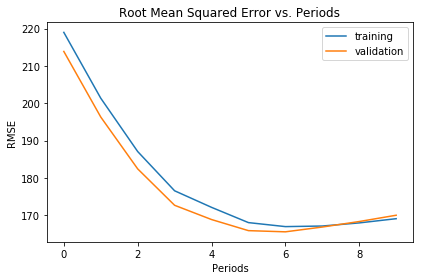

In [50]:
linear_regressor = train_model(
    learning_rate = 0.00003,
    steps = 500,
    batch_size = 5,
    training_examples = training_examples_randomized,
    training_targets = training_targets_randomized,
    validation_examples = validation_examples_randomized,
    validation_targets = validation_targets_randomized
)

## Evaluate on Test Data

We've done lot of iteration on the validation data. Let's make sure we haven't overfit to the pecularities of that particular sample.

In [51]:
california_housing_test_data = pd.read_csv("https://dl.google.com/mlcc/mledu-datasets/california_housing_test.csv", sep=",")

test_examples = preprocess_features(california_housing_test_data)
test_targets = preprocess_targets(california_housing_test_data)

predict_test_input_fn = lambda: my_input_fn(
    test_examples,
    test_targets["median_house_value"],
    num_epochs=1,
    shuffle=False
)

test_predictions = linear_regressor.predict(input_fn=predict_test_input_fn)
test_predictions = np.array([item["predictions"][0] for item in test_predictions])

root_mean_squared_error = math.sqrt(
    metrics.mean_squared_error(test_predictions, test_targets)
)

print("Final RMSE (on test data): %0.2f" % root_mean_squared_error)

Final RMSE (on test data): 162.66
